# Compare Workflows: LCIA QSAR Project
**Date:** May 18, 2023

This notebook compares workflows for predicting oral points of departure of chemicals via supervised machine learning. Several workflows are compared using a repeated k-fold internal cross-validation scheme. Each workflow differs with respect to the data source, type of LD50 values as a feature, and whether missing data are included in the features:

    - Data from CompTox (OPERA & TEST) vs. OPERA 2.9
    
    - Experimental vs. predicted LD50 values as a feature
    
    - Missing data included in the features vs. complete data. If missing, then preprocessing includes feature selection & imputation of missing values. 

In [1]:
import pandas as pd
import numpy as np
from os import path

import plot
import configuration as config
from workflow_lcia import LciaQsarModelingWorkflow
# Enable modules to be imported from the parent directory.
import sys
sys.path.append('..')
from common.input_output import combine_csv_files
from common.estimators import instantiate_all_estimators

In [2]:
data_attribute_levels = [
    ['general'], 
    config.features_sources, 
    config.ld50_types, 
    config.data_conditions
]
data_attr_combinations = config.cartesian_product(data_attribute_levels)

data_attr_combinations

[('general', 'comptox', 'experimental', 'missing'),
 ('general', 'comptox', 'experimental', 'complete'),
 ('general', 'comptox', 'predicted', 'missing'),
 ('general', 'comptox', 'predicted', 'complete'),
 ('general', 'opera', 'experimental', 'missing'),
 ('general', 'opera', 'experimental', 'complete'),
 ('general', 'opera', 'predicted', 'missing'),
 ('general', 'opera', 'predicted', 'complete')]

## Configure the workflows

Define the workflows as the cartesian product of three sets:
- Source of feature data: `{CompTox, OPERA}`
- Type of LD50 value: `{experimental, predicted}`
- Condition of the feature data: `{missing, complete}`

For workflows involving missing feature data, limited feature selection is performed by removing a given feature only if the proportion of missing values (in the training set) exceeds the specified threshold.

In [3]:
workflow = LciaQsarModelingWorkflow(
    config.file_path_surrogate_pods,
    config.file_path_for_source,
    config.file_path_ld50_experimental,
    config.ld50_pred_column_for_source, 
    config.use_experimental_for_ld50, 
    config.drop_missing_for_condition,
    config.pre_steps_for_condition,
)

## Instantiate the estimators
For each workflow, we do not know *a priori* which estimator(s) will perform best. We will therefore try all the available estimators for regression in the scikit-learn and XGBoost libraries, while accepting default hyperparameters.

In [4]:
attributes_dict = {
    'random_state' : config.RANDOM_STATE_ESTIMATOR, 
    'n_jobs' : config.N_JOBS
} 

estimator_for_name = instantiate_all_estimators(
    names_to_exclude=config.estimators_to_exclude,
    attributes=attributes_dict
)

estimator_for_name['RandomForestRegressor'].max_features = config.MAX_FEATURES

## Define global parameters for the cross-validation scheme
The original pipeline for feature preprocessing may not be appropriate depending on which features are used for a given workflow and their numerical values (e.g., discrete). I therefore refactored the workflow to exclude some features from preprocessing in the following cases:

    - BasicFeatureSelector: Exclude from the correlation assessment (if applicable) any features that are discrete
    - Log10Transformer: Exclude any features that are discrete or may contain null or negative values
    - SelectiveScaler: Exclude any features that are discrete

## Compare performances across workflows & estimators

### Implement the cross-validation scheme
For each workflow-estimator combination, the scheme involves 50 randomized repeats of a 5-fold cross-validation. The same data partitions are used for each estimator to enable comparison.

In [5]:
%%time 

cv_results_for_combination = workflow.repeated_kfold_for_combinations(
    data_attr_combinations, 
    list(estimator_for_name.values()), 
    config.function_for_metric, 
    config.combination_names,  
    n_splits=config.N_SPLITS_OUTER, 
    n_repeats=config.N_REPEATS_CV_OUTER, 
    random_state=config.RANDOM_STATE_CV_OUTER
)

# For backwards compatibility, 
cv_results_for_combination = cv_results_for_combination.droplevel(0, axis=1)

# TODO: Move writing directly into the function.
cv_write_name = f"cross-validation-{config.N_SPLITS}-fold-{config.N_REPEATS_CV}-repeats.csv"
cv_write_path = path.join(config.path_results_dir, cv_write_name)
cv_results_for_combination.to_csv(cv_write_path)

C:\Users\jkvas\.conda\envs\chiu-lab\Lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\jkvas\.conda\envs\chiu-lab\Lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\jkvas\.conda\envs\chiu-lab\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\User

C:\Users\jkvas\Google Drive\My Drive\Work\TAMU\Projects\Repositories\chiu-lab\lcia_qsar\..\common\features.py:202: UserWarning: data may contain non-continuous columns: dtypes [dtype('int64')]
  warnings.warn(
C:\Users\jkvas\Google Drive\My Drive\Work\TAMU\Projects\Repositories\chiu-lab\lcia_qsar\..\common\features.py:202: UserWarning: data may contain non-continuous columns: dtypes [dtype('int64')]
  warnings.warn(
C:\Users\jkvas\Google Drive\My Drive\Work\TAMU\Projects\Repositories\chiu-lab\lcia_qsar\..\common\features.py:202: UserWarning: data may contain non-continuous columns: dtypes [dtype('int64')]
  warnings.warn(
C:\Users\jkvas\Google Drive\My Drive\Work\TAMU\Projects\Repositories\chiu-lab\lcia_qsar\..\common\features.py:202: UserWarning: data may contain non-continuous columns: dtypes [dtype('int64')]
  warnings.warn(
C:\Users\jkvas\Google Drive\My Drive\Work\TAMU\Projects\Repositories\chiu-lab\lcia_qsar\..\common\features.py:202: UserWarning: data may contain non-continuous 

C:\Users\jkvas\Google Drive\My Drive\Work\TAMU\Projects\Repositories\chiu-lab\lcia_qsar\..\common\features.py:202: UserWarning: data may contain non-continuous columns: dtypes [dtype('int64')]
  warnings.warn(
C:\Users\jkvas\Google Drive\My Drive\Work\TAMU\Projects\Repositories\chiu-lab\lcia_qsar\..\common\features.py:202: UserWarning: data may contain non-continuous columns: dtypes [dtype('int64')]
  warnings.warn(
C:\Users\jkvas\Google Drive\My Drive\Work\TAMU\Projects\Repositories\chiu-lab\lcia_qsar\..\common\features.py:202: UserWarning: data may contain non-continuous columns: dtypes [dtype('int64')]
  warnings.warn(
C:\Users\jkvas\Google Drive\My Drive\Work\TAMU\Projects\Repositories\chiu-lab\lcia_qsar\..\common\features.py:202: UserWarning: data may contain non-continuous columns: dtypes [dtype('int64')]
  warnings.warn(
C:\Users\jkvas\Google Drive\My Drive\Work\TAMU\Projects\Repositories\chiu-lab\lcia_qsar\..\common\features.py:202: UserWarning: data may contain non-continuous 

AttributeError: module 'configuration' has no attribute 'N_SPLITS'

### Visualize model performance scores

In [6]:
## Define plot parameters. 

metrics_keys = [
    'r2_score',
    'root_mean_squared_error',
    'median_absolute_error'
]
ascendings = [False, True, True]
xlabels = [
    '$R^2$',
    'Root-Mean-Squared Error',
    'Median Absolute Error '
]
xlims = [(0., 1.), (0., 2.), (0., 2.)]

title_for_key = {
    ('experimental', 'complete') : 'Complete, Experimental',
    ('experimental', 'missing') : 'Missing, Experimental',
    ('predicted', 'complete') : 'Complete, Predicted',
    ('predicted', 'missing') : 'Missing, Predicted'
}
figsize = (10., 10.)

C:\Users\jkvas\Google Drive\My Drive\Work\TAMU\Projects\Repositories\chiu-lab\lcia_qsar\plot.py:148: PerformanceWarning: indexing past lexsort depth may impact performance.
  scores_long.loc[best_workflow]
C:\Users\jkvas\Google Drive\My Drive\Work\TAMU\Projects\Repositories\chiu-lab\lcia_qsar\plot.py:157: PerformanceWarning: indexing past lexsort depth may impact performance.
  wf : scores_long.loc[wf].loc[sorted_index].reset_index()
C:\Users\jkvas\Google Drive\My Drive\Work\TAMU\Projects\Repositories\chiu-lab\lcia_qsar\plot.py:157: PerformanceWarning: indexing past lexsort depth may impact performance.
  wf : scores_long.loc[wf].loc[sorted_index].reset_index()
C:\Users\jkvas\Google Drive\My Drive\Work\TAMU\Projects\Repositories\chiu-lab\lcia_qsar\plot.py:157: PerformanceWarning: indexing past lexsort depth may impact performance.
  wf : scores_long.loc[wf].loc[sorted_index].reset_index()
C:\Users\jkvas\Google Drive\My Drive\Work\TAMU\Projects\Repositories\chiu-lab\lcia_qsar\plot.py:15

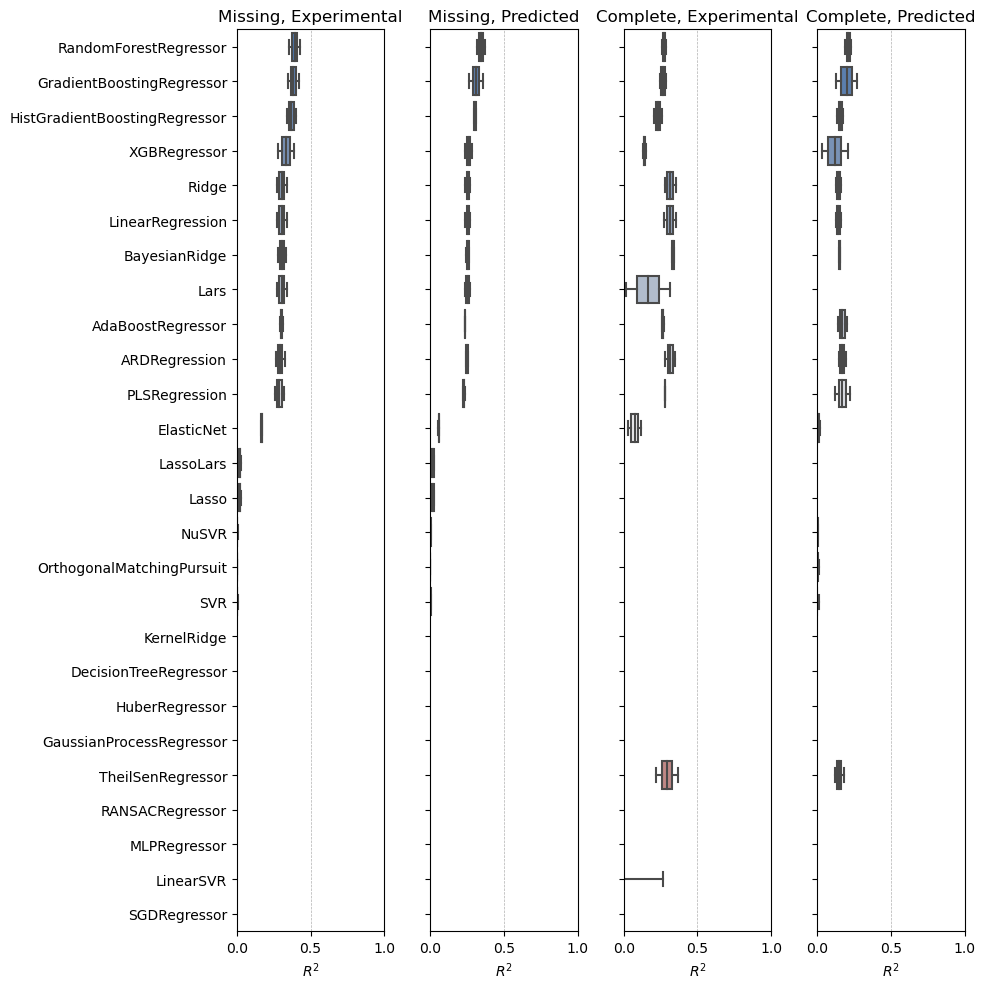

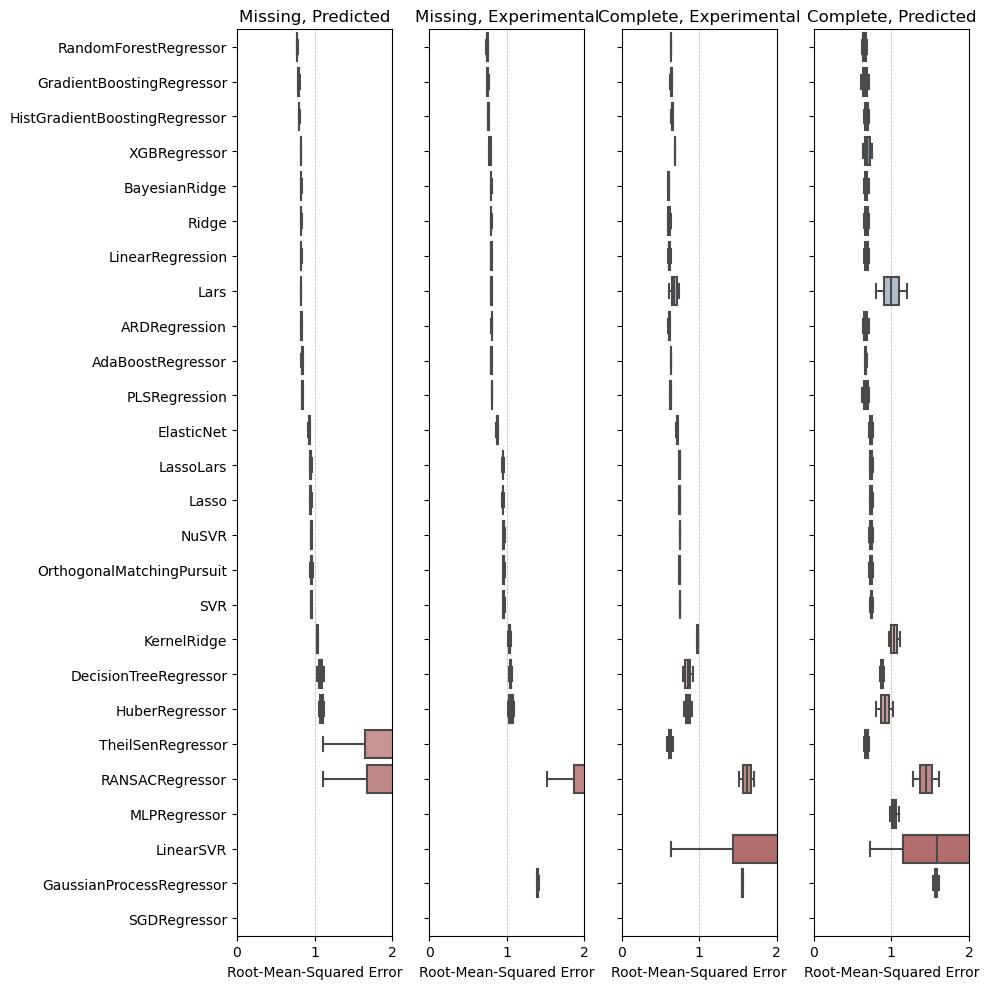

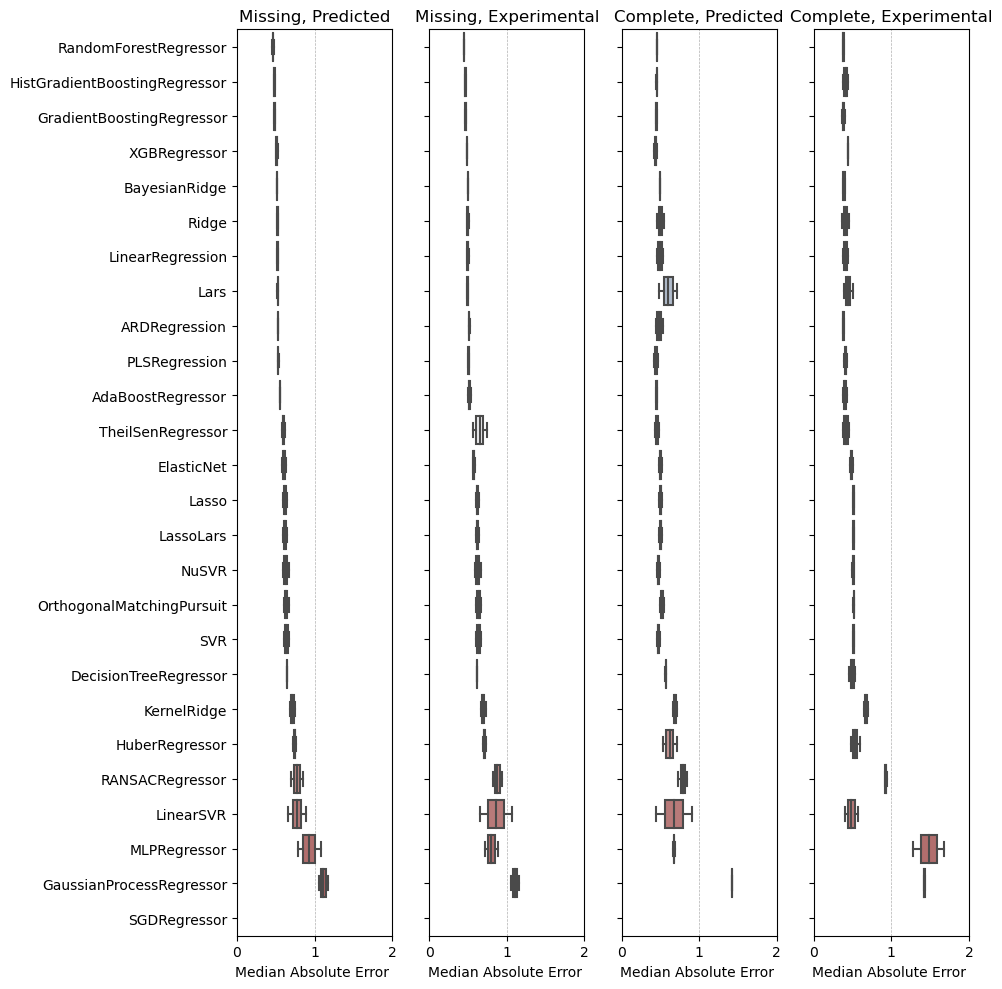

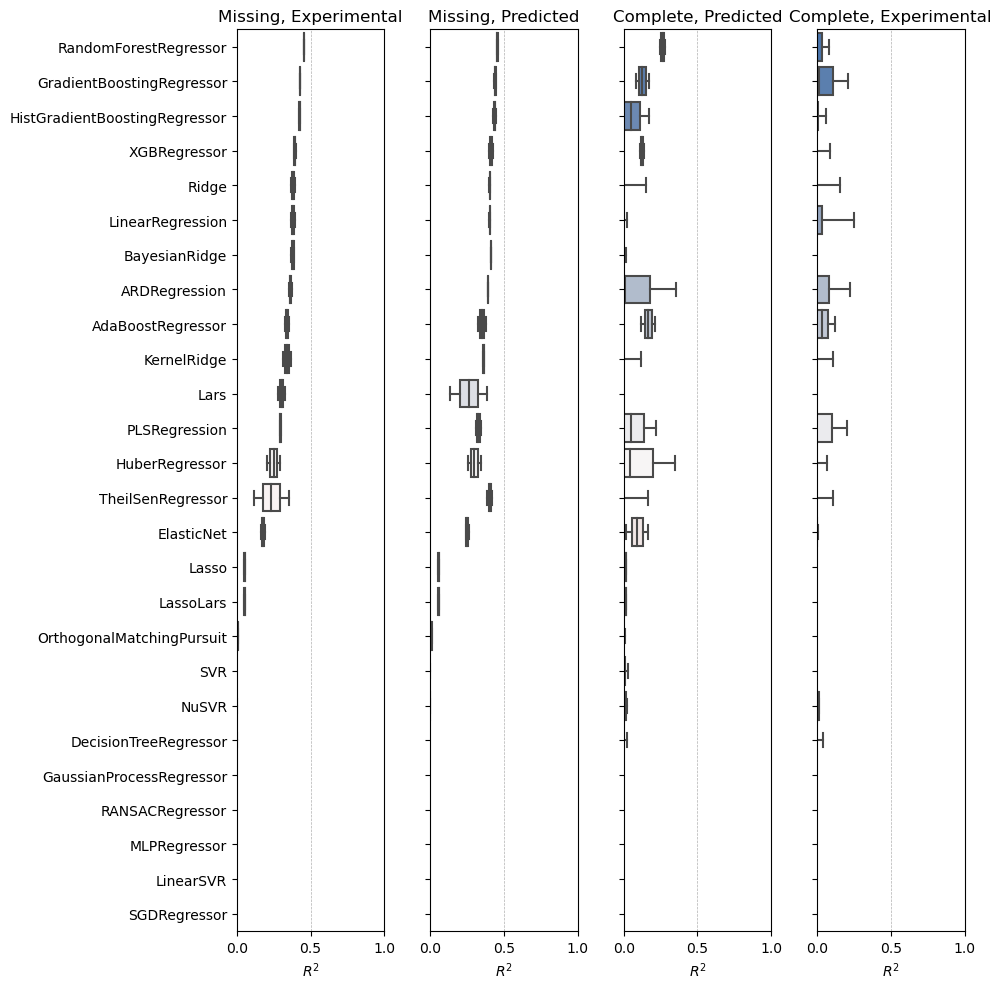

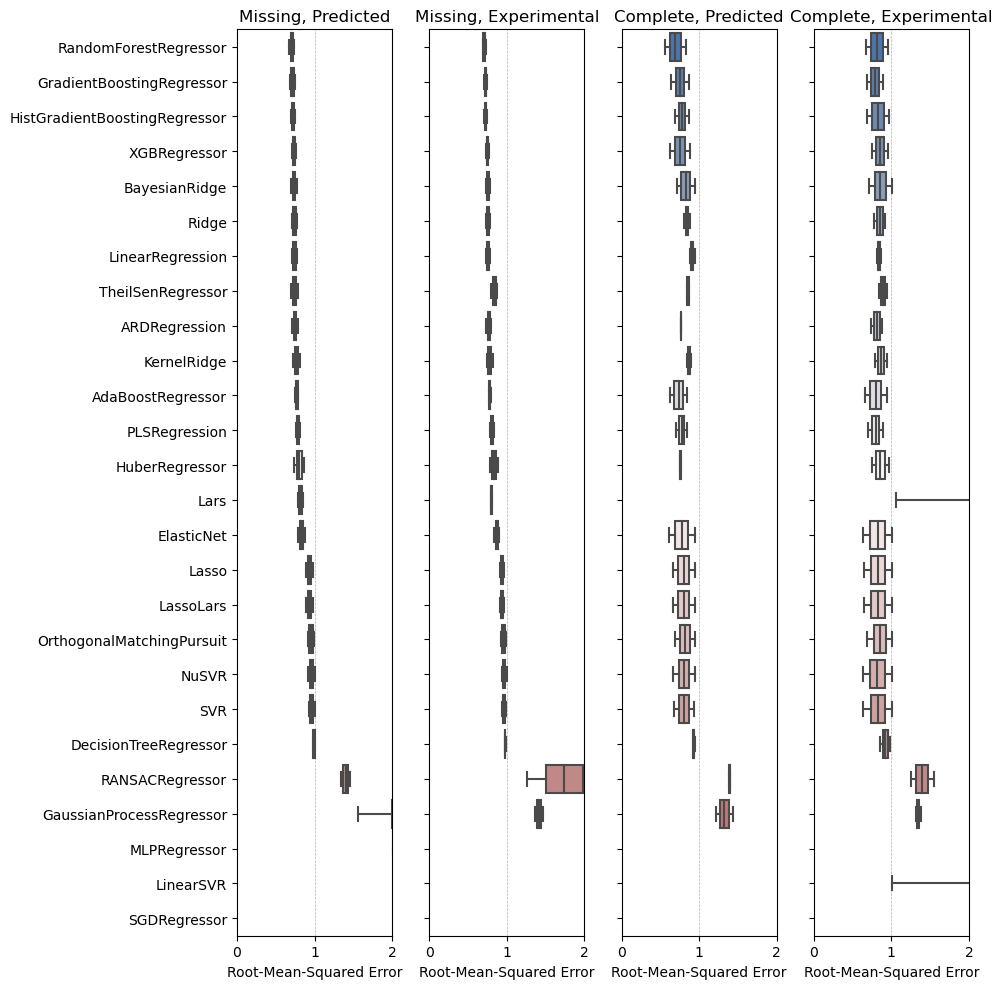

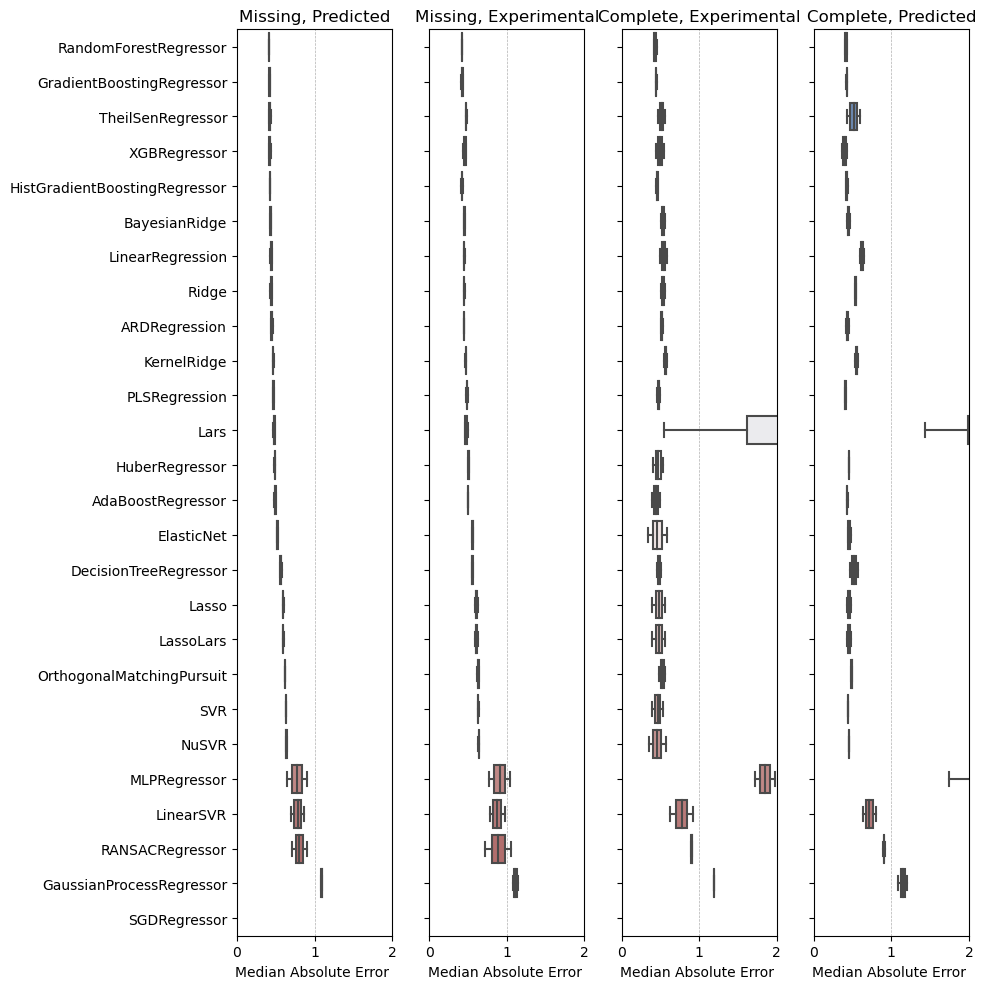

In [8]:
plot_for = plot.vertical_boxplots_for_cv_results(
    cv_results_for_combination, 
    metrics_keys, 
    ascendings, 
    xlabels, 
    xlims, 
    title_for_key=title_for_key, 
    figsize=figsize, 
    write_dir=config.path_figures_dir
)